<a href="https://colab.research.google.com/github/OwenHuels/data-science/blob/main/Owen_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [ ]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [ ]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [ ]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

Text(0, 0.5, 'FG%')

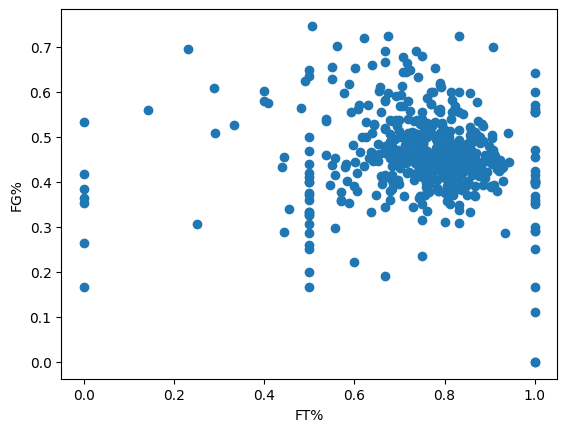

In [ ]:
#make scatter plot of FT% and FG% for NBA players form the 23/24 season
plt.scatter(basketball['FT%'] , basketball['FG%'],)

#label axes
plt.xlabel("FT%")
plt.ylabel("FG%")

I notice that there are a lot of players with free throw percentages of 0, 50, and 100 percent. This is because there are a lot of players in the NBA who barely play at all during the season before getting dropped from the team or sent to the G-League. This means they might only attempt one set of two free throws in the season, so if they make both, that's 100%, miss both is 0%, and one make one miss is 50%. Other than this trend, most players are concentrated around 75% FT% and 45% FG%. This make sense to me to be around the average for these percentages in the NBA, so that's probably why they trend this way.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

In [ ]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = basketball.Pos.cat.codes.values

#an array of the strings that represent position
pos_codes = basketball.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bb_coords = {"pos": pos_codes}

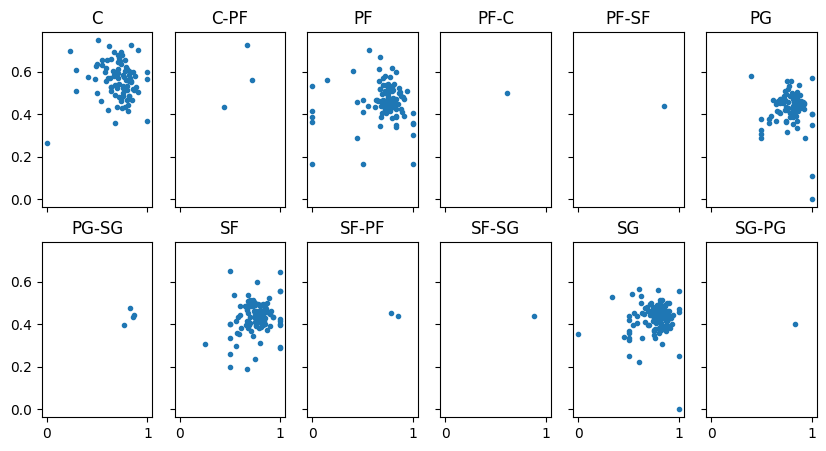

In [ ]:
#set up the 12 plots
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

The centers and power forwards still seem to have some negative relationship between FT% and FG%, although it is much more vague than before. The plots now have a lot more outliers that wouldn't be accounted for by our previous trends. There seems to be even less of a relationship for all position other than C and PF than before.

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

In [ ]:
#nh for non hierarchical
with pm.Model(coords=bb_coords) as nh_model:
    #priors
    α = pm.Normal("α", mu=0, sigma=3, dims="pos")
    β = pm.Normal("β", mu=0, sigma=10, dims="pos")
    σ = pm.HalfNormal("σ", 1)

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[pos_idx] + β[pos_idx] * basketball['FT%'],
                  sigma=σ,
                  observed=basketball['FG%'])
    idata_nh_b = pm.sample(target_accept=0.99)

/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:1278: ImputationWarning: Data in y_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'α': array([-0.24452009, -0.23033715,  0.12118448,  0.64353167, -0.70805195,
       -0.66355224,  0.38285402,  0.93479978,  0.95658579,  0.44792791,
       -0.26477173,  0.12838182]), 'β': array([ 0.97913654, -0.48724099, -0.99249399,  0.14393604, -0.97961149,
       -0.330607  ,  0.02175197,  0.77978971, -0.32475021,  0.83826038,
       -0.38979568, -0.80332404]), 'σ_log__': array(-0.51284697), 'y_pred_unobserved': array([nan, nan, nan, nan])}

Logp initial evaluation results:
{'α': -24.42, 'β': -38.69, 'σ': -0.92, 'y_pred_unobserved': nan, 'y_pred_observed': nan}
You can call `model.debug()` for more details.

This model won't run because of the high leverage values present in the center and power forward graphs. The model is trying to guess wildly different slopes and intercepts because of these vaues that don't fit within the trend we saw when we removed these high leverage values from the model in the notes. It basically allows for a massive amount of slopes and intercepts to be possible, meaning it is impossible for the model to make predictions at all.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [2]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [3]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

Text(0, 0.5, 'weight')

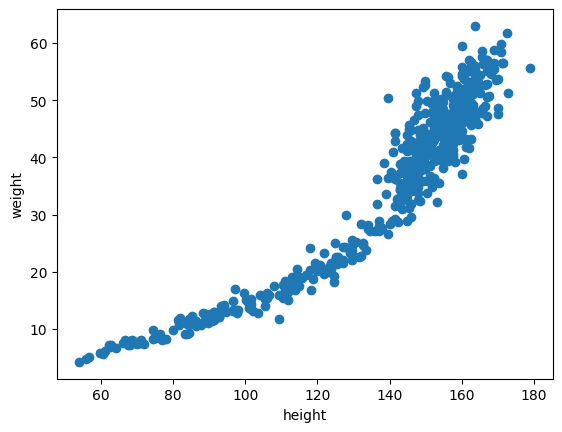

In [ ]:
#make scatter plot of weight and height for the Kalahari !Kung San people
plt.scatter(howell['height'] , howell['weight'],)

#label axes
plt.xlabel("height")
plt.ylabel("weight")

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [13]:
#lkks stands for linear kalahari !kung san
with pm.Model() as model_lkks:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_lkks = pm.sample()

Output()

Output()

Text(0, 0.5, 'weight')

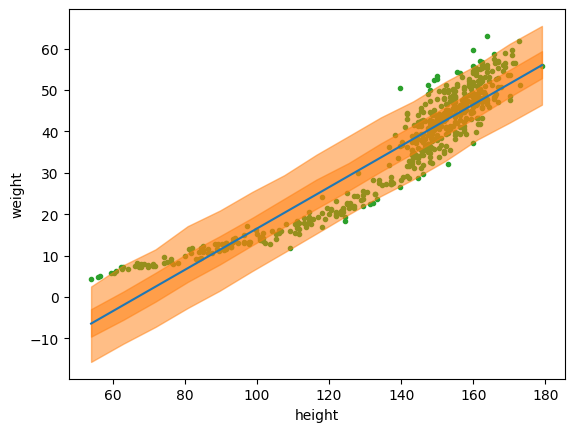

In [17]:
mean_line = idata_lkks.posterior["μ"].mean(("chain", "draw"))
heights = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(heights)
x = np.linspace(heights.min(), heights.max(), 15)
y_pred_q = idata_lkks.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(heights[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [15]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_lkks, model = model_lkks, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

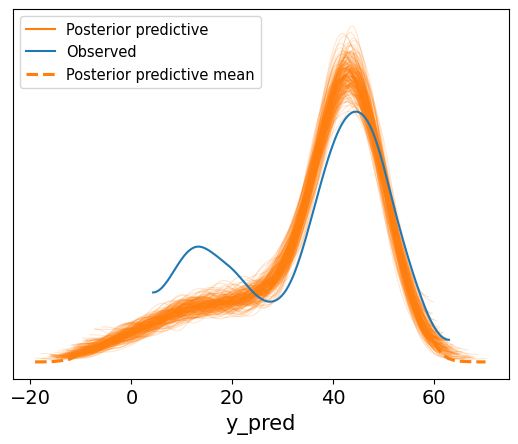

In [16]:
# posterior predictive check
az.plot_ppc(idata_lkks, num_pp_samples=200, colors=["C1", "C0", "C1"])

The model does not fit the observed data very well. There's one major problem, being the lack of that second bump on the left side. The peak is also a little bit off from where the data peaks. There are some negative weight values predicted, which obviously shouldn't be possible.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [6]:
with pm.Model() as model_vvkks:
    # Priors for the mean line
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=5)

    # Priors for the standard deviation line
    γ = pm.Normal("γ", mu=0, sigma=2)
    δ = pm.Normal("δ", mu=0, sigma=2)

    # Mean line
    μ = pm.Deterministic("μ", pm.math.exp(α + β * howell.height))

    # Variance line
    σ = pm.Deterministic("σ", pm.math.exp(γ + δ * howell.height))

    # Normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_vvkks = pm.sample(tune=2000, draws=1000, target_accept=0.99)

Output()

Output()

Text(0, 0.5, 'weight')

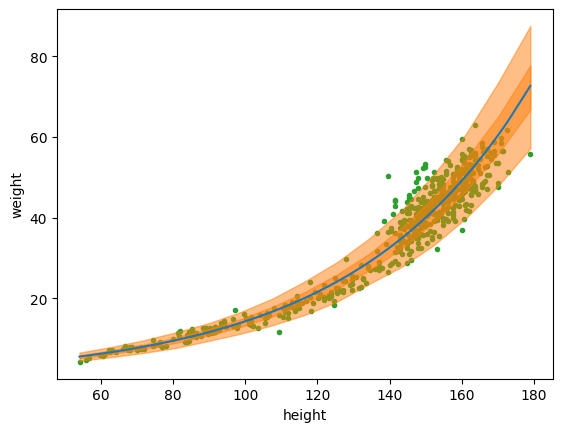

In [11]:
mean_line = idata_vvkks.posterior["μ"].mean(("chain", "draw"))
heights = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(heights)
x = np.linspace(heights.min(), heights.max(), 15)
y_pred_q = idata_vvkks.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(heights[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

In [8]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_vvkks, model = model_vvkks, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

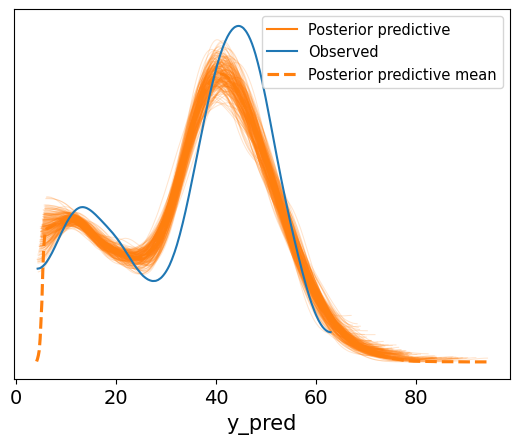

In [9]:
# posterior predictive check
az.plot_ppc(idata_vvkks, num_pp_samples=200, colors=["C1", "C0", "C1"])

This model fits the data really well! It has basically the exact same shape as the observed data, but is just slightly off to the right across most of the distribution. I'm not sure how to fix this, but this model is a pretty good one. It no longer has the problem of returning negative values, and also has the two peaks we were looking for.